Check Python version

In [160]:
!python --version

Python 3.11.11


Import libraries

In [161]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [162]:
# Local directory
# data_dir = '../datasets/air_quality'
# file_name = 'air_quality'
file_path = 'air_quality.csv'

In [163]:
dataset = pd.read_csv(file_path)
dataset=dataset.head(500)

In [164]:
dataset.shape

(500, 14)

In [165]:
dataset.columns

Index(['datetime', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'RH', 'AH', 'T'],
      dtype='object')

In [166]:
dataset.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,10-03-2004 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,48.9,0.7578,13.6
1,10-03-2004 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,47.7,0.7255,13.3
2,10-03-2004 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,54.0,0.7502,11.9
3,10-03-2004 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,60.0,0.7867,11.0
4,10-03-2004 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,59.6,0.7888,11.2


In [167]:
dataset.tail()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
495,31-03-2004 09:00,2.2,1262,216,8.6,924,181,872,125,1576,1093,74.4,0.9384,10.4
496,31-03-2004 10:00,1.7,1197,117,6.5,837,144,957,118,1498,965,71.0,0.9582,11.5
497,31-03-2004 11:00,1.9,1277,156,7.7,886,140,902,109,1579,1004,70.0,0.9924,12.2
498,31-03-2004 12:00,2.9,1430,332,11.3,1025,204,779,123,1772,1166,73.3,1.0442,12.3
499,31-03-2004 13:00,2.2,1242,232,9.1,944,149,846,114,1638,991,78.1,1.0411,11.3


Define the required time and target columns

In [168]:
time_col = dataset.columns[0]
dataset[time_col] = pd.to_datetime(dataset[time_col], format="%d-%m-%Y %H:%M", errors='coerce')
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [169]:
# dataset[target_col] = dataset[target_col].astype(float)

In [170]:
# dataset.head()

Split dataset into train and test sets

In [171]:
train_size = 0.9
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

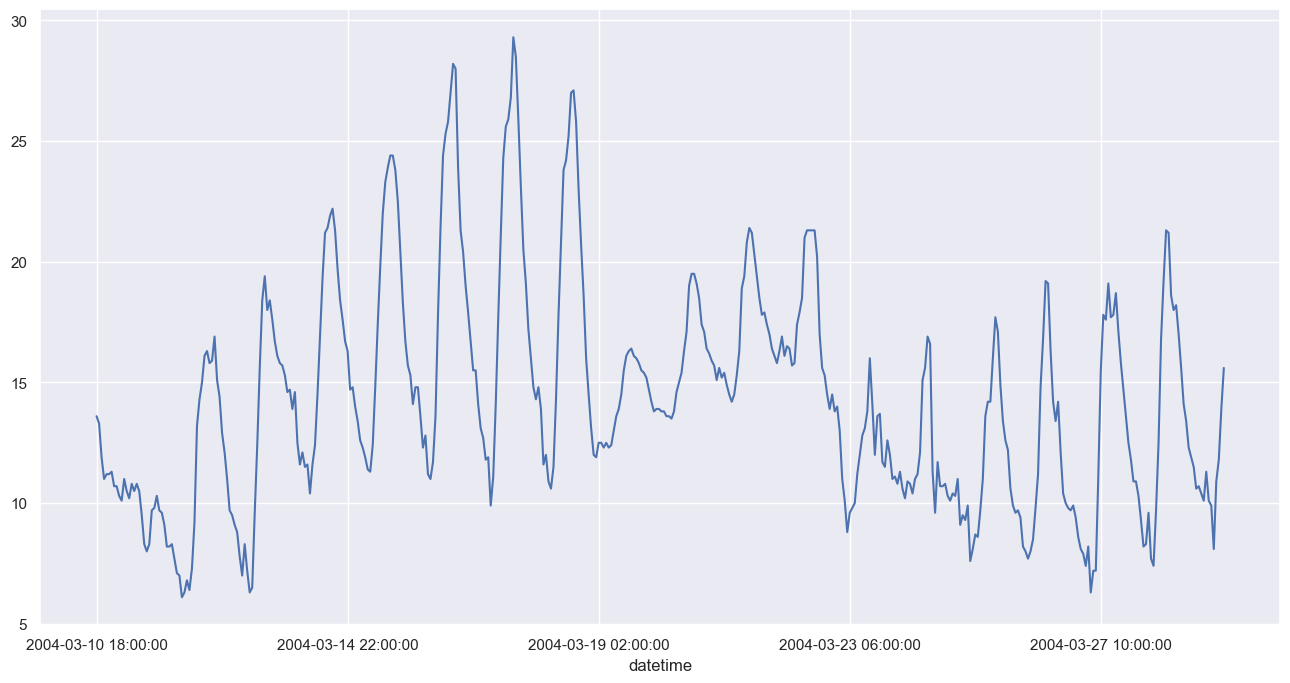

In [172]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [173]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [174]:
train_data[:2]

[['2004-03-10 18:00:00',
  2.6,
  1360,
  150,
  11.9,
  1046,
  166,
  1056,
  113,
  1692,
  1268,
  48.9,
  0.7578,
  13.6],
 ['2004-03-10 19:00:00',
  2.0,
  1292,
  112,
  9.4,
  955,
  103,
  1174,
  92,
  1559,
  972,
  47.7,
  0.7255,
  13.3]]

Custom Model Request (optional)

In [175]:
# Default model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             # {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'darts_autoets'},
#         ],
#     },
# }

# # Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# # np_external_model_request = None

user_value = 0.80
output_type = 'estimate'  # 'data', 'estimate'
mauq_external_params = {
    'problem_type': 'regression',
    'confidence_level': user_value,
    'output_type': output_type

}

deepsybil_external_model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            # {'type': 'dartsimputer'},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            # {'type': 'darts_tcn',
            #  'params': {
            #      'output_chunk_length': 52,
            #      'input_chunk_length': 104,                 
            #      'n_epochs': 20,
            # }},
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            # {'type': 'darts_nlinear'},
            # {'type': 'darts_dlinear'},
            # {'type': 'darts_blockrnn'},
            {'type': 'darts_tsmixer',
             'params': {
                 'output_chunk_length': 24,
                 'input_chunk_length': 48,                 
                 'n_epochs': 50,
            }},
            #  {'type': 'darts_tsmixer'}
        ],
    },
}


# # Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            # {'type': 'dartsimputer'},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            # {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_naive'},
            # {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            # {'type': 'darts_autoets'},
            # {'type': 'stats_autoets'},
            # {'type': 'darts_autoarima'},
            # {'type': 'stats_autoarima'},
            # {'type': 'darts_autoces'},
            # {'type': 'darts_kalman'},
            # {'type': 'darts_catboost'},            
            # # {'type': 'darts_tbats'},
            # # {'type': 'darts_linearregression'},
            # {'type': 'darts_lightgbm',
            #  'params': {
            #      'lags': 12,
            #      'output_chunk_length': 6,
            #      'verbose': -1
            # }}
            # {'type': 'neuralprophet',
            #  'external_params': np_external_model_request
            # }  # Onboard NeuralProphet external service
            {'type': 'deepsybil',
             'external_params': deepsybil_external_model_request
            }  # Onboard NeuralProphet external service
        ],
        
    },
    'mauq_params':mauq_external_params,
}

This is for JSON model_request

In [176]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [177]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [178]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [179]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [180]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [181]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [182]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 3min 28s


In [183]:
train_json_out = response.json()

In [184]:
estimate=train_json_out['estimate']

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [185]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [186]:
test_data[:2]

[['2004-03-29 12:00:00',
  1.4,
  971,
  91,
  5.5,
  786,
  92,
  1129,
  78,
  1272,
  546,
  29.0,
  0.5406],
 ['2004-03-29 13:00:00',
  1.6,
  1010,
  146,
  6.5,
  833,
  91,
  1070,
  83,
  1332,
  561,
  27.9,
  0.5517]]

Model from Train API

In [187]:
model = train_json_out['model']

Forecast API JSON Payload

In [188]:
api_json = {
    'model': model,
    'data': test_data,
    'estimate':estimate
}

Build URL (same as train except for the endpoint)

In [189]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [190]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 863 ms


In [191]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['2004-03-29 12:00:00',
   19.323626467582944,
   15.642315105433497,
   23.00493782973239],
  ['2004-03-29 13:00:00',
   18.643629414624314,
   14.962318052474867,
   22.32494077677376],
  ['2004-03-29 14:00:00',
   20.489800759646855,
   16.808489397497407,
   24.171112121796302],
  ['2004-03-29 15:00:00',
   18.881830715796486,
   15.200519353647039,
   22.563142077945933],
  ['2004-03-29 16:00:00',
   17.057886027853726,
   13.376574665704279,
   20.739197390003174],
  ['2004-03-29 17:00:00',
   18.119007345748724,
   14.437695983599276,
   21.80031870789817],
  ['2004-03-29 18:00:00',
   16.640533988943005,
   12.959222626793558,
   20.321845351092453],
  ['2004-03-29 19:00:00',
   15.368947893788867,
   11.68763653163942,
   19.050259255938315],
  ['2004-03-29 20:00:00',
   14.869864554719266,
   11.188553192569817,
   18.551175916868715],
  ['2004-03-29 21:00:00',
   13.507218425867286,
   9.825907063717839,
   17.188529788016734],
  ['2004-03-29 22:00:00',
   13.48748

Combine forecast dates and output

In [192]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col,"lower_interval","upper_interval"],
)

In [193]:
forecast_df.shape

(50, 4)

In [194]:
forecast_df.columns

Index(['datetime', 'T', 'lower_interval', 'upper_interval'], dtype='object')

In [195]:
forecast_df.head()

,datetime,T,lower_interval,upper_interval
0,2004-03-29 12:00:00,19.323626,15.642315,23.004938
1,2004-03-29 13:00:00,18.643629,14.962318,22.324941
2,2004-03-29 14:00:00,20.489801,16.808489,24.171112
3,2004-03-29 15:00:00,18.881831,15.200519,22.563142
4,2004-03-29 16:00:00,17.057886,13.376575,20.739197


In [196]:
forecast_df.tail()

,datetime,T,lower_interval,upper_interval
45,2004-03-31 09:00:00,15.213170,11.531859,18.894481
46,2004-03-31 10:00:00,16.689379,13.008068,20.370691
47,2004-03-31 11:00:00,18.753562,15.072251,22.434873
48,2004-03-31 12:00:00,20.132496,16.451185,23.813808
49,2004-03-31 13:00:00,21.528710,17.847399,25.210021


Plot train and forecast side-by-side

C:\Users\saira\AppData\Local\Temp\ipykernel_4052\2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


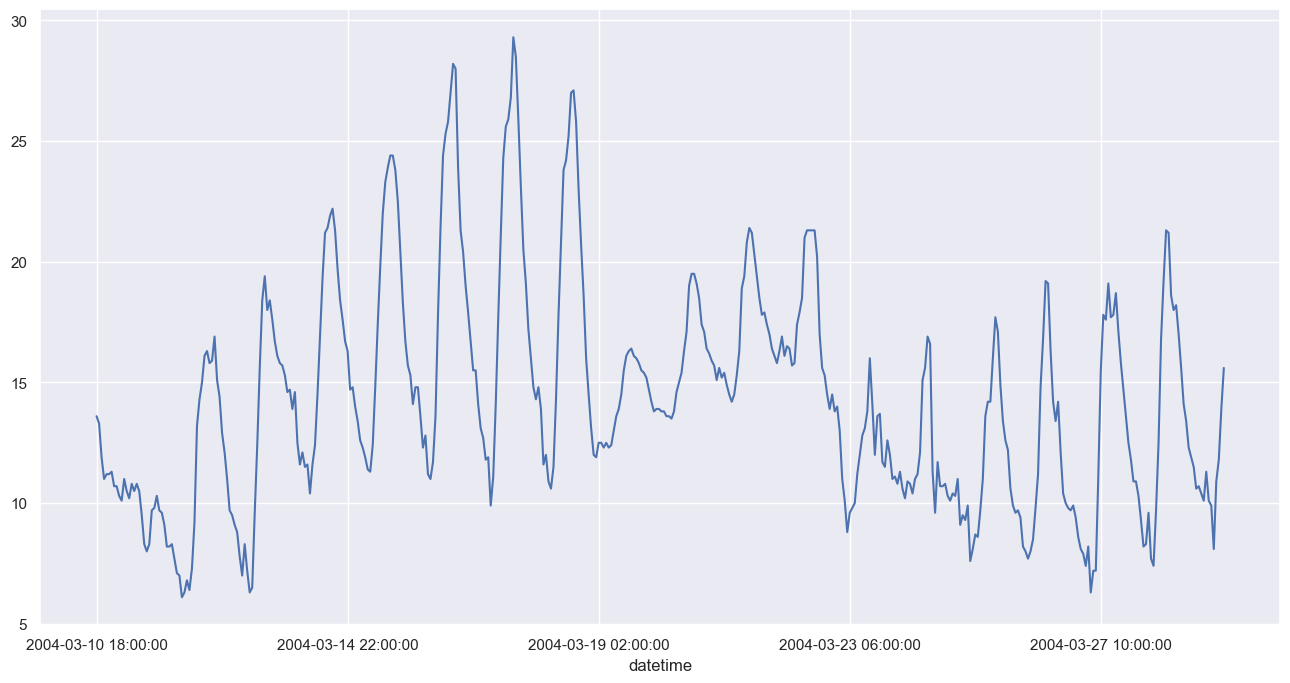

In [197]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

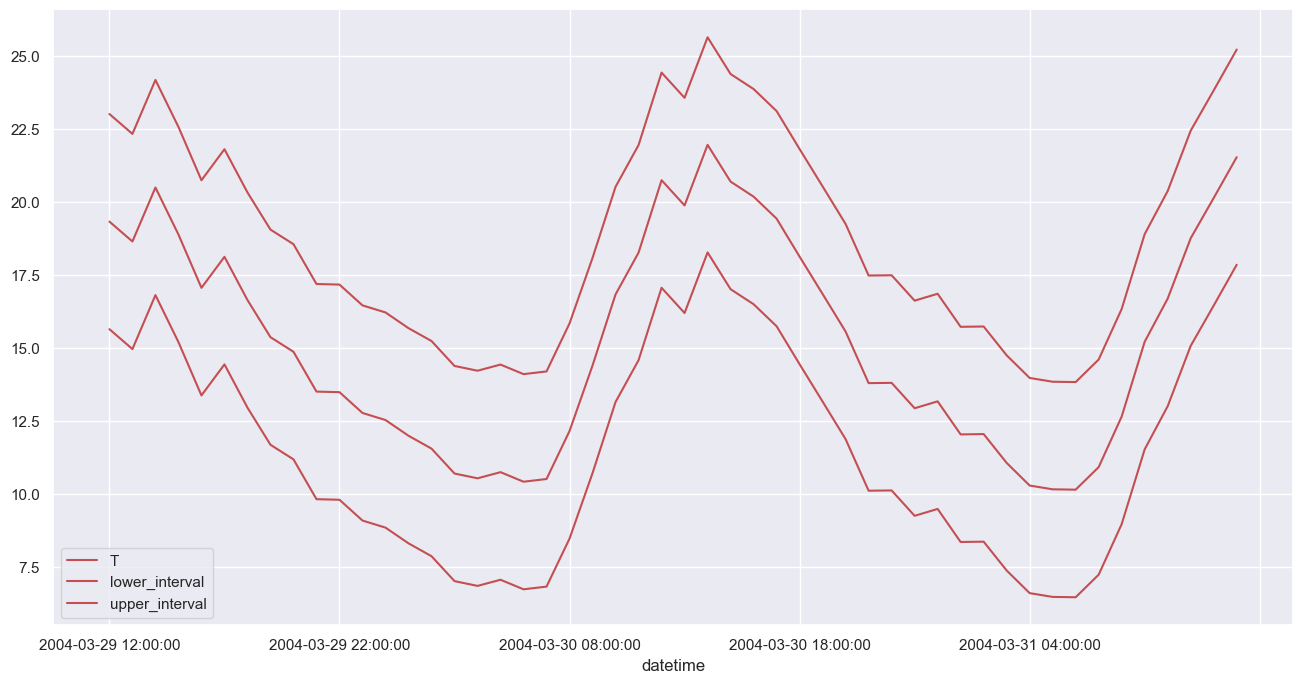

In [198]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [199]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [200]:
df.shape

(500, 17)

In [201]:
df.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T,color,lower_interval,upper_interval
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,13.6,b,NaN,NaN
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,13.3,b,NaN,NaN
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,11.9,b,NaN,NaN
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,11.0,b,NaN,NaN
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,11.2,b,NaN,NaN


In [202]:
df.tail()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T,color,lower_interval,upper_interval
495,2004-03-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.213170,r,11.531859,18.894481
496,2004-03-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.689379,r,13.008068,20.370691
497,2004-03-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.753562,r,15.072251,22.434873
498,2004-03-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.132496,r,16.451185,23.813808
499,2004-03-31 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.528710,r,17.847399,25.210021


In [203]:
dataset

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,48.9,0.7578,13.6
1,2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,47.7,0.7255,13.3
2,2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,54.0,0.7502,11.9
3,2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,60.0,0.7867,11.0
4,2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,59.6,0.7888,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2004-03-31 09:00:00,2.2,1262,216,8.6,924,181,872,125,1576,1093,74.4,0.9384,10.4
496,2004-03-31 10:00:00,1.7,1197,117,6.5,837,144,957,118,1498,965,71.0,0.9582,11.5
497,2004-03-31 11:00:00,1.9,1277,156,7.7,886,140,902,109,1579,1004,70.0,0.9924,12.2
498,2004-03-31 12:00:00,2.9,1430,332,11.3,1025,204,779,123,1772,1166,73.3,1.0442,12.3


Plot combined train and forecast sets with the vertical black line as the cut-off

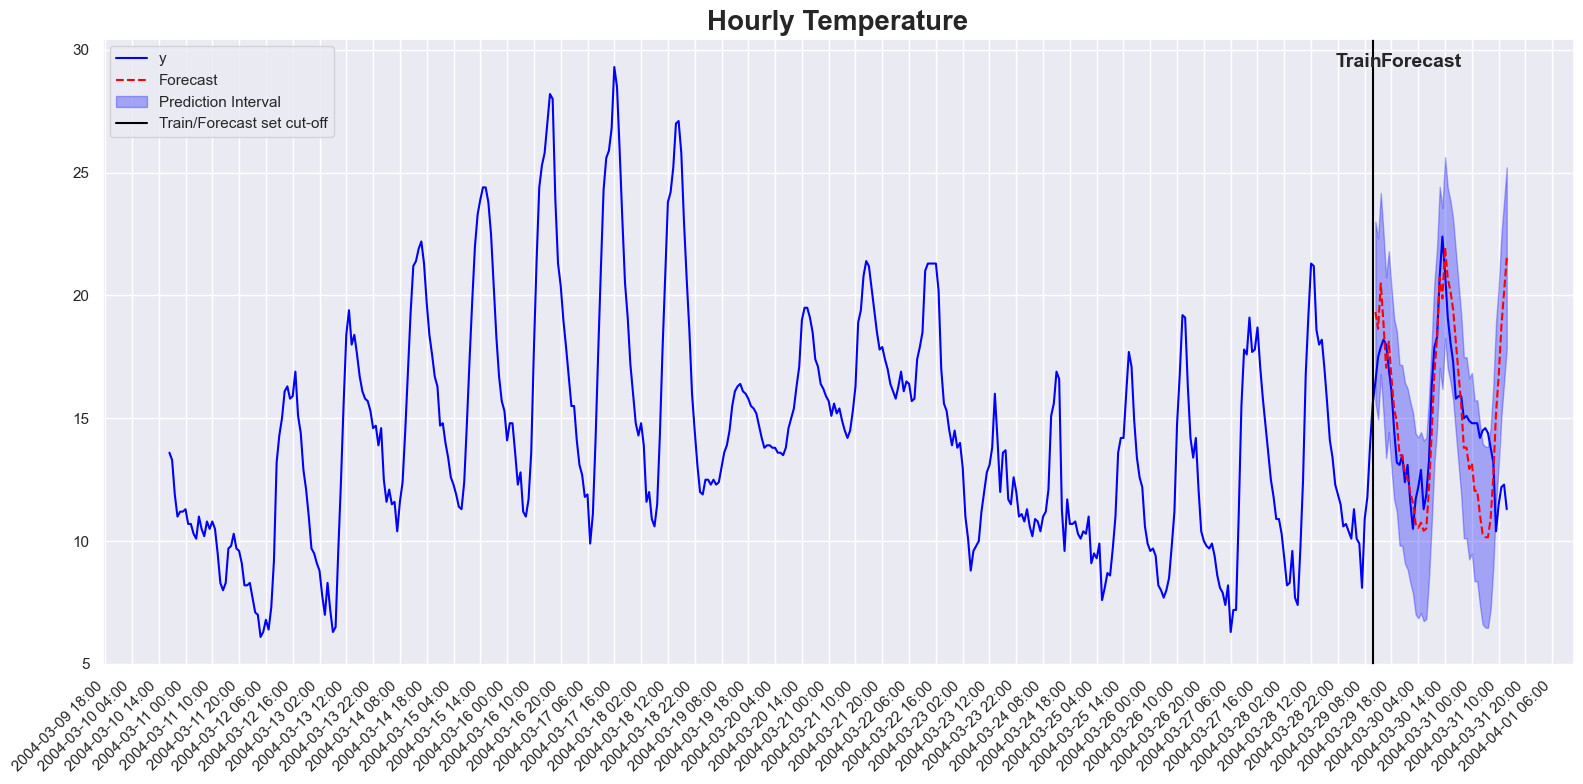

In [204]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df[time_col] = pd.to_datetime(df[time_col])
forecast_df[time_col] = pd.to_datetime(forecast_df[time_col])

plt.figure(figsize=figsize)

dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%Y-%m')

plt.plot(dataset[time_col], dataset[target_col], color='blue', label='y')
plt.plot(forecast_df[time_col], forecast_df[target_col], color='red', linestyle='dashed', label='Forecast')

plt.fill_between(
    forecast_df[time_col],
    forecast_df['lower_interval'],
    forecast_df['upper_interval'],
    color='blue',
    alpha=0.3,
    label='Prediction Interval'
)

plt.axvline(x=df[time_col].iloc[len(train_df)-1], color='black', label='Train/Forecast set cut-off')

plt.text(df[time_col].iloc[len(train_df)-15], df[target_col].max(), 'Train', fontweight='bold', fontsize=14)
plt.text(df[time_col].iloc[len(train_df)+2], df[target_col].max(), 'Forecast', fontweight='bold', fontsize=14)

ax = plt.gca()

# Show ticks every hour and format as YYYY‑MM‑DD HH:MM
ax.xaxis.set_major_locator(mdates.HourLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.title('Hourly Temperature', fontweight='bold', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()
